# Petbreed Multiclassification

Try out the working classifier on our live web app!

https://mypetbreed.onrender.com/


After prototyping different ideas, we figured out what model architechture worked best from using Azure Data Science VM with how quickly we were able to get it set up. In order to train at images at a higher resolution and batch size, we moved over to train our final production model on [Wayde's Deep Learning Rig](https://waydegg.github.io/making-a-dl-server.html#making-a-dl-server) so we wouldn't have to spend any money for GPU/storage. Shoutout to George for getting our model working live on the web!

We'll start with loading in the Fastai Deep Learning library, as it's what Wayde's most comfortable using. Tanveer's models with Tensorflow 2.0 were used for reference.

In [73]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [74]:
from fastai.vision import *

Since there are multiple GPU's in the DL Rig, we have to specify which one to train on.

In [75]:
torch.cuda.set_device(0)
print(f'Using GPU#{torch.cuda.current_device()}')

Using GPU#0


## Configuration

Next we'll configure our path's and setup some parameters we'll be changing throughout the training process to scale the model with increasing image resolution.

In [76]:
PATH = Path('data')
TRAIN = PATH/'train'
TEST = PATH/'test'

In [100]:
# bs,sz = 128,32
# bs,sz = 64,64
# bs,sz = 32,128
# bs,sz = 16,256
bs,sz = 8,512

prefix = "med_"

## Data Prep

Before anything, we need to prepare our data for modeling. With how the raw files are structured, the steps we'll need to take are:

1. Match image files to breed names. Since the file names are just numbers and the breed names are IDs in a csv, we need to make a function that pairs the two together for when we setup our [Databunch](https://docs.fast.ai/data_block.html).
2. Upsample imageset. Since we're limited to train with only a few thousand images in total, our training and validation accuracy should increase if we have more data to train with. Because of this, we can duplicate our training set several times to "artificially" get a bigger dataset. We'll avoid overfitting by appying unique image transforms to all these images so that each image is different than the rest, increasing the generalization of our model.
3. Create a databunch. Using Fastai's Datablock API, we'll create a databunch that uses our labeling function and upsampled dataset to split our training dataset into training and validation subsets. We'll also apply image transforms using Fastai's `vision.transform` package.

In [78]:
PATH.ls()

[PosixPath('data/train.csv'),
 PosixPath('data/sampleSubmission_breed.csv'),
 PosixPath('data/export.pkl'),
 PosixPath('data/models'),
 PosixPath('data/large'),
 PosixPath('data/ucsd-2019-datathon.zip'),
 PosixPath('data/train'),
 PosixPath('data/test'),
 PosixPath('data/image.zip')]

In [79]:
train_df = pd.read_csv(PATH/'train.csv', engine='python')
train_df.head()

,breedID,speciesID,fname,breed_name
0,23,2,0,newfoundland
1,35,2,1,staffordshire bull terrier
2,19,2,2,keeshond
3,2,2,3,american bulldog
4,29,2,4,saint bernard


In [80]:
train_df.breed_name.unique()

array(['newfoundland', 'staffordshire bull terrier', 'keeshond', 'american bulldog', 'saint bernard', 'Russian Blue',
       'Bengal', 'yorkshire terrier', 'samoyed', 'beagle', 'miniature pinscher', 'Persian', 'scottish terrier', 'pug',
       'shiba inu', 'pomeranian', 'great pyrenees', 'boxer', 'Sphynx', 'Bombay', 'Egyptian Mau',
       'english cocker spaniel', 'havanese', 'Ragdoll', 'german shorthaired', 'British Shorthair', 'english setter',
       'japanese chin', 'Birman', 'chihuahua', 'leonberger', 'wheaten terrier', 'Siamese', 'Abyssinian',
       'basset hound', 'Maine Coon', 'american pit bull terrier'], dtype=object)

### Upsampling

Lets cycle through our Training set 5 times to generate a bigger dataset:

In [10]:
LARGE = PATH/'large'
LARGE.mkdir(exist_ok=True)

In [12]:
%%time
amt = os.listdir(TRAIN)
amt_len = len(amt)
mult_amt = 5
i = 1

while i < mult_amt:
    n = 0
    while n < amt_len:
        amt.append(amt[n][:-4] + '_copy_' + str(i) + '.jpg')
        os.system(f'cp {TRAIN}/{amt[n]} {LARGE}/{amt[n][:-4]}_copy_{str(i)}.jpg')
        n+=1
        if n%250 == 0:
            print(n)
    i+=1
    
    print(i)

250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
2
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
4
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
5
CPU times: user 865 ms, sys: 44.5 s, total: 45.3 s
Wall time: 2min 23s


### Datablock

Below is our labeling function for matching image file names with breed ids. We will input this into our databunch when we create it later:

In [84]:
# Labeling function used by Datablock API
def get_labels(fname):    
    fname = str(fname) # Convert path object to string
    fname = fname.split(sep='/')
    
    if fname[1] == "train":
        fname = fname[len(fname) - 1]
        fname = fname[:-4]

        row = train_df.loc[train_df['fname'] == int(fname)]
        label = row["breed_name"].values[0]
        
    if fname[1] == "large":
        fname = fname[len(fname) - 1]
        fname = fname[:-11]

        row = train_df.loc[train_df['fname'] == int(fname)]
        label = row["breed_name"].values[0]
        
    return label

**Fastai Base Transforms**

We'll be using Fastai's ``get_transforms()`` funtion get a set of image transforms. Because our dataset is pictures of animals, we'll be using transforms that would generate new images that we could potentially see in the other 70% of the test set:

- do_flip: if True, a random flip is applied with probability 0.5
- flip_vert: requires do_flip=True. If True, the image can be flipped vertically or rotated of 90 degrees, otherwise only an h orizontal flip is applied
- max_rotate: if not None, a random rotation between -max_rotate and max_rotate degrees is applied with probability p_affine
- max_zoom: if not 1. or less, a random zoom betweem 1. and max_zoom is applied with probability p_affine
- max_lighting: if not None, a random lightning and contrast change controlled by max_lighting is applied with probability p_lighting
- max_warp: if not None, a random symmetric warp of magnitude between -max_warp and maw_warp is applied with probability p_affine
- p_affine: the probability that each affine transform and symmetric warp is applied
- p_lighting: the probability that each lighting transform is applied
- xtra_tfms: a list of additional transforms you would like to be applied

In [101]:
%%time
# Datablock
data = (ImageList.from_folder(TRAIN) # Change to "TRAIN" or "LARGE" as needed
        .split_by_rand_pct()
        .label_from_func(get_labels)
        .transform(get_transforms(), size=sz)
        .databunch(bs=bs).normalize(imagenet_stats))

CPU times: user 5.08 s, sys: 19.5 ms, total: 5.1 s
Wall time: 1.77 s


After successfully creating our databunch, let's look at some animals!

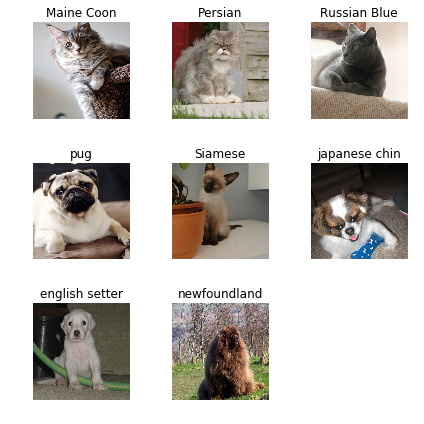

In [102]:
data.show_batch(rows=3, figsize=(6,6))

In [103]:
data

ImageDataBunch;

Train: LabelList (2944 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
saint bernard,scottish terrier,Ragdoll,wheaten terrier,japanese chin
Path: data/train;

Valid: LabelList (736 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
Sphynx,Persian,boxer,shiba inu,Bengal
Path: data/train;

Test: None

In [104]:
len(os.listdir(LARGE))

14721

In [105]:
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau', 'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx', 'american bulldog', 'american pit bull terrier', 'basset hound', 'beagle', 'boxer', 'chihuahua', 'english cocker spaniel', 'english setter', 'german shorthaired', 'great pyrenees', 'havanese', 'japanese chin', 'keeshond', 'leonberger', 'miniature pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint bernard', 'samoyed', 'scottish terrier', 'shiba inu', 'staffordshire bull terrier', 'wheaten terrier', 'yorkshire terrier']


Now that our databunch is setup, its time to do some modeling.

## Modeling

From testing various pretrained models and architechures out on the Azure VM, we saw best results with using a resnet50 architecture in a Convolutional Nerual Network. InceptionV3 wasnt getting nearly as good accuracy as Resnet50 (or Resnet34) and Vgg wasn't either. 

In [106]:
gc.collect()

19780

Now we'll create our learner class and load in some metrics we care about (error rate and accuracy):

In [107]:
learn = cnn_learner(data, models.resnet50, metrics=(error_rate,accuracy))

In [108]:
learn.path = PATH
os.system(f"mv {TRAIN}/models {PATH}")

256

Lets find the learning rate we'll want to use by using Fastai's lr finder:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


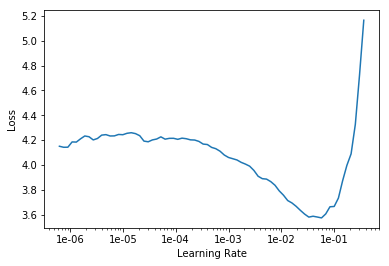

In [109]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-2

Time to train! After our prototying accuracy seemed to pleateau around 15 epochs, so that's the numbe we'll go with here:

In [ ]:
learn.fit_one_cycle(15, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.078608,0.452293,0.139946,0.860054,01:06
1,0.810311,0.379908,0.114130,0.885870,01:06
2,1.144765,0.432375,0.116848,0.883152,01:06
3,0.936179,0.317194,0.082880,0.917120,01:06
4,0.956811,1.686913,0.123641,0.876359,01:07
5,0.934229,2.578762,0.133152,0.866848,01:06
6,0.713250,2.577781,0.123641,0.876359,01:07
7,0.709498,2.726692,0.130435,0.869565,01:07
8,0.519696,9.890393,0.148098,0.851902,01:07
9,0.484012,14.130372,0.133152,0.866848,01:07


In [ ]:
learn.save(f"{prefix}first")

In [ ]:
learn.load(f"{prefix}first");

To update the earlier weights in the normalized model (using imagenet for the normalization), we'll unfreeze all the layers and train at a lower learning rate:

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find(start_lr=1e-10, end_lr=1e-5)
learn.recorder.plot()

In [98]:
learn.fit_one_cycle(5, max_lr=slice(1e-9,1e-7))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.100357,0.206127,0.070652,0.929348,00:25
1,0.089417,0.182813,0.070652,0.929348,00:25
2,0.117301,0.198399,0.065217,0.934783,00:25
3,0.100709,0.208291,0.065217,0.934783,00:25
4,0.108423,0.196405,0.066576,0.933424,00:25


In [99]:
learn.save(f"{prefix}second")

With ~95% validation accuracy, we were satisfied with our model. Now to get predictions for our test set!

## Submission

Since we looked at image file names and breed types, we need to write a function that changes the category we're looking at to `breedID` instead. First we'll make an infrence learner to get the predictions of the test set images, then feed our results into a pandas dataframe which will be exported into a csv for Kaggle.

In [43]:
samp_df = pd.read_csv(PATH/'sampleSubmission_breed.csv')
samp_df.head()

,fname,breedID
0,0,23
1,1,35
2,2,19
3,3,2
4,4,29


Getting predictions for test set:

In [57]:
# Create infrence learner
learn = cnn_learner(data, models.resnet50, metrics=(error_rate,accuracy))
learn.path = PATH
os.system(f"mv {TRAIN}/models {PATH}")
os.system(f"mv {LARGE}/models {PATH}")

# Load best model
learn.load(f"{prefix}second");

In [61]:
# Create Submission Dataframe
samp_data = {'fname':[], 'breedID':[]}
sub_df = pd.DataFrame(samp_data)
sub_df

,fname,breedID


In [63]:
%%time
count = 0
dataset = TEST

for image in os.listdir(TEST):    
    # File names
    fname = image[:-4]
    
    # breed_id predictions
    img = open_image(str(TEST/image))
    breed_pred = learn.predict(img)[0]
    temp_df = train_df.loc[train_df['breed_name'] == f"{breed_pred}"]
    id_pred = temp_df.values[0][0]
    
    temp_data = {'fname':[fname], 'breedID':[id_pred]}
    temp_sub_df = pd.DataFrame(samp_data)   
    sub_df.loc[count] = [fname, id_pred]
    
    if count%250 == 0:
        print(f"{count} of {len(os.listdir(TEST))} done.")
    count += 1

0 of 3669 done.
250 of 3669 done.
500 of 3669 done.
750 of 3669 done.
1000 of 3669 done.
1250 of 3669 done.
1500 of 3669 done.
1750 of 3669 done.
2000 of 3669 done.
2250 of 3669 done.
2500 of 3669 done.
2750 of 3669 done.
3000 of 3669 done.
3250 of 3669 done.
3500 of 3669 done.
CPU times: user 2min 20s, sys: 8.91 s, total: 2min 29s
Wall time: 2min 31s


In [65]:
sub_df.sort_values(by=["fname"], inplace=True)
sub_df.reset_index(inplace=True)
sub_df.drop(["index"], axis=1, inplace=True)
sub_df["breedID"] = sub_df["breedID"].apply(int)
sub_df.head()

,fname,breedID
0,3680,11.0
1,3681,30.0
2,3682,26.0
3,3683,23.0
4,3684,19.0


In [70]:
sub_df.shape

(3669, 2)

In [71]:
sub_df.to_csv('submission.csv', index=False)

We'll also export our model so we can use it in our Web App:

In [72]:
learn.export()

## Analysis

Let's look at our results!

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

Below are several images that our model had the most trouble on. If we had more time to work on this project, we'd adjust our training datset accordingly so that we generate more augmented images of each class which should help eliminate some of these losses:

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

If we look at the confusion matrix below, we can see a vizualization of the model's performance on all the breeds. The more linear and darker the line from the top right to bottom left is, the more accurate the model:

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

We can also look at what the model was most unsure about, meaning the activations for all the classes we were looking at were all about even, and the model couldn't decide on one that stood out more from the rest:

In [ ]:
interp.most_confused(min_val=2)